# 03 - Hero Lane Outcomes
Extraction des stats early game par lane/hero.


In [ ]:
import os
import sys
from pathlib import Path
ROOT = Path(os.getcwd()).resolve()
if (ROOT / 'src').exists():
    sys.path.append(str(ROOT))
elif (ROOT.parent / 'src').exists():
    sys.path.append(str(ROOT.parent))
else:
    sys.path.append(str(ROOT))

raw_candidates = [
    ROOT / 'data/raw/data.json',
    ROOT.parent / 'data/raw/data.json',
]
raw_path = next((p for p in raw_candidates if p.exists()), None)
if raw_path is None:
    raise FileNotFoundError(f'data/raw/data.json introuvable. Cherché: {raw_candidates}')

processed_dir = ROOT / 'data/processed'
processed_dir.mkdir(parents=True, exist_ok=True)

import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.dota_data import read_processed_tables, lane_phase_features, match_header, write_parquet_tables

sns.set_theme(style='whitegrid')

if not (processed_dir / 'matches.parquet').exists():
    write_parquet_tables(raw_path, processed_dir)

tables = read_processed_tables(processed_dir)
matches = match_header(tables['matches'])
players = tables['players']

minute = 10
lane_feats = lane_phase_features(players, minute=minute)
lane_df = lane_feats.to_pandas()
lane_df.head()
display(lane_df.shape())


,match_id,player_slot,is_radiant,hero_id,lane,lane_role,gpm,xpm,lh_m10,dn_m10,gold_m10,xp_m10
0,8592272555,0,True,10,1,1,784,793,65,12,4229,3684
1,8592272555,1,True,137,2,2,549,598,47,2,3891,4605
2,8592272555,2,True,49,3,3,642,859,60,7,3154,3230
3,8592272555,3,True,89,1,1,425,454,5,0,1474,1600
4,8592272555,4,True,79,3,3,296,447,14,0,1583,1483


In [5]:
lane_df

,match_id,player_slot,is_radiant,hero_id,lane,lane_role,gpm,xpm,lh_m10,dn_m10,gold_m10,xp_m10
0,8592272555,0,True,10,1,1,784,793,65,12,4229,3684
1,8592272555,1,True,137,2,2,549,598,47,2,3891,4605
2,8592272555,2,True,49,3,3,642,859,60,7,3154,3230
3,8592272555,3,True,89,1,1,425,454,5,0,1474,1600
4,8592272555,4,True,79,3,3,296,447,14,0,1583,1483
...,...,...,...,...,...,...,...,...,...,...,...,...
495,8514308079,128,False,66,1,3,371,380,22,2,2004,2195
496,8514308079,129,False,70,3,1,606,595,63,16,4155,3589
497,8514308079,130,False,35,2,2,579,567,64,14,4244,4913
498,8514308079,131,False,96,1,3,609,678,61,9,3847,3657


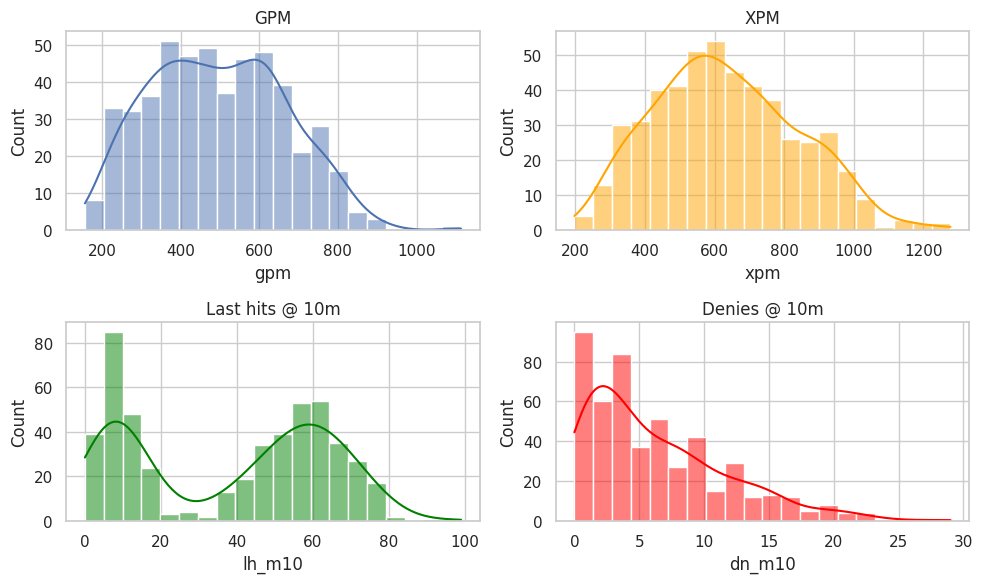

In [2]:
# Distributions GPM/XPM et LH/DN à 10 min
fig, axes = plt.subplots(2,2, figsize=(10,6))
sns.histplot(lane_df['gpm'].dropna(), bins=20, ax=axes[0,0], kde=True)
axes[0,0].set_title('GPM')
sns.histplot(lane_df['xpm'].dropna(), bins=20, ax=axes[0,1], kde=True, color='orange')
axes[0,1].set_title('XPM')
sns.histplot(lane_df[f'lh_m{minute}'].dropna(), bins=20, ax=axes[1,0], kde=True, color='green')
axes[1,0].set_title(f'Last hits @ {minute}m')
sns.histplot(lane_df[f'dn_m{minute}'].dropna(), bins=20, ax=axes[1,1], kde=True, color='red')
axes[1,1].set_title(f'Denies @ {minute}m')
plt.tight_layout()
plt.show()


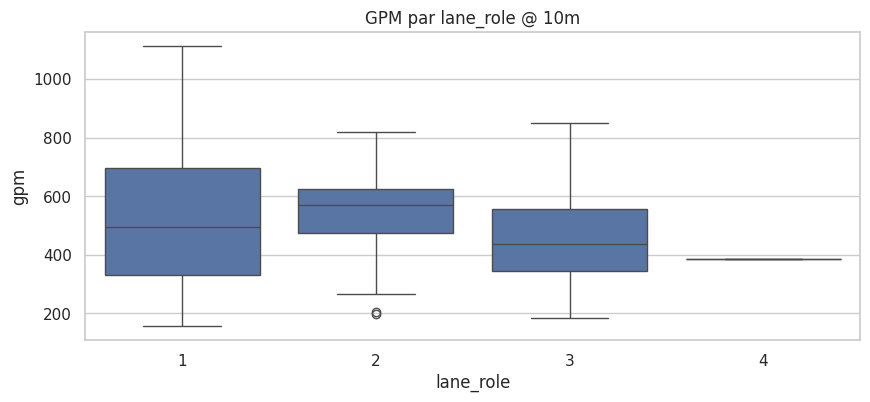

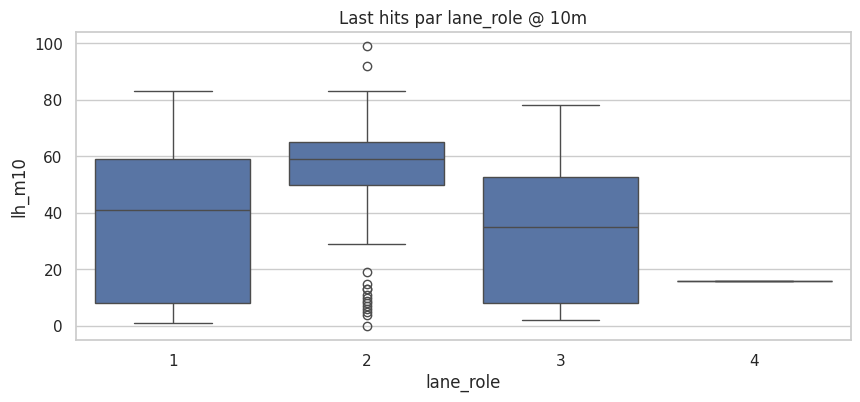

In [3]:
# Comparaison par lane_role (1=safe, 2=mid, 3=offlane, 4/5 supports)
plt.figure(figsize=(10,4))
sns.boxplot(data=lane_df, x='lane_role', y='gpm')
plt.title(f'GPM par lane_role @ {minute}m')
plt.show()

plt.figure(figsize=(10,4))
sns.boxplot(data=lane_df, x='lane_role', y=f'lh_m{minute}')
plt.title(f'Last hits par lane_role @ {minute}m')
plt.show()


In [4]:
# Top 10 heros par GPM moyen
top_gpm = lane_df.groupby('hero_id')['gpm'].mean().sort_values(ascending=False).head(10)
top_gpm


hero_id
10    791.750000
41    774.000000
46    763.666667
94    745.000000
34    736.000000
53    710.142857
25    699.000000
63    696.333333
40    675.000000
95    667.400000
Name: gpm, dtype: float64